In [1]:
import os
import pandas as pd 
import numpy as np
import imageio

import random
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
from collections import defaultdict


import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!unzip /content/data_500_compressed.zip

In [6]:
data = "/content/data_500/"

In [4]:
classes = ['surprise',
            "fear",
            "contempt",
            "disgust",
            "anger",
            "neutrality",
            "sadness",
            "happiness"]

In [7]:
check_dr = [data+"/train/", data+"/val/", data+"/test/"]
for dr in check_dr:
    print(f"##########{dr}###########")
    for dir_ in os.listdir(dr):
        count = 0
        for f in os.listdir(dr + dir_ + "/"):
            count += 1
        print(f"{dir_}:   \t {count} images")

##########/content/data_500//train/###########
anger:   	 450 images
surprise:   	 450 images
happiness:   	 450 images
disgust:   	 450 images
fear:   	 450 images
sadness:   	 450 images
neutrality:   	 450 images
##########/content/data_500//val/###########
anger:   	 25 images
surprise:   	 25 images
happiness:   	 25 images
disgust:   	 25 images
fear:   	 25 images
sadness:   	 25 images
neutrality:   	 25 images
##########/content/data_500//test/###########
anger:   	 25 images
surprise:   	 25 images
happiness:   	 25 images
disgust:   	 25 images
fear:   	 25 images
sadness:   	 25 images
neutrality:   	 25 images


# Basic Model

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(224, 224, 1)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])

In [14]:
train_dir = data+'train/'
train_datagen = ImageDataGenerator(rescale=1.0/255., 
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest'
                                    )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    classes=['surprise',
                                                            "fear",
                                                            "disgust",
                                                            "anger",
                                                            "neutrality",
                                                            "sadness",
                                                            "happiness"],
                                                    class_mode="categorical",
                                                    color_mode="grayscale",
                                                    target_size=(224, 224))
val_dir= data+'val/'
validation_datagen = ImageDataGenerator(rescale=1.0/255.)

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              batch_size=32,
                                                              classes=['surprise',
                                                                        "fear",
                                                                        "disgust",
                                                                        "anger",
                                                                        "neutrality",
                                                                        "sadness",
                                                                        "happiness"],
                                                              class_mode="categorical",
                                                              color_mode="grayscale",
                                                              target_size=(224, 224)
                                                             
                                                             )

Found 3150 images belonging to 7 classes.
Found 175 images belonging to 7 classes.


In [15]:
history = model.fit(train_generator,
                              epochs=100,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/100
99/99 [==============================] - 14s 131ms/step - loss: 2.0438 - acc: 0.1524 - val_loss: 1.9270 - val_acc: 0.1771
Epoch 2/100
99/99 [==============================] - 13s 131ms/step - loss: 1.9324 - acc: 0.1822 - val_loss: 1.9728 - val_acc: 0.1886
Epoch 3/100
99/99 [==============================] - 13s 130ms/step - loss: 1.9188 - acc: 0.1894 - val_loss: 1.9143 - val_acc: 0.2286
Epoch 4/100
99/99 [==============================] - 13s 129ms/step - loss: 1.9089 - acc: 0.1999 - val_loss: 1.9137 - val_acc: 0.1829
Epoch 5/100
99/99 [==============================] - 13s 130ms/step - loss: 1.9025 - acc: 0.2224 - val_loss: 1.9258 - val_acc: 0.2000
Epoch 6/100
99/99 [==============================] - 13s 130ms/step - loss: 1.9012 - acc: 0.2165 - val_loss: 1.9328 - val_acc: 0.1829
Epoch 7/100
99/99 [==============================] - 13s 130ms/step - loss: 1.8979 - acc: 0.2061 - val_loss: 1.9841 - val_acc: 0.1771
Epoch 8/100
99/99 [==============================] - 13s 131ms

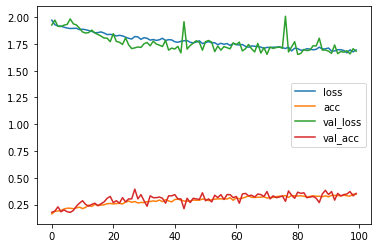

In [17]:
pd.DataFrame(history.history).plot();

# Transfer Learning

### VGG16

In [34]:
import tensorflow as tf
from tensorflow import keras 
from keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import Xception

In [25]:
def load_model():
    model = VGG16(weights="imagenet", include_top=False, classes=7, 
                  input_shape=(224, 224, 3), classifier_activation="softmax")
    return model
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False 
    return model

def add_last_layers(model):
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(7, activation='softmax')
    
    
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    
    return model

def compile_model(model):
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

def build_model():
    
    model = load_model()
    model = add_last_layers(model)
    model = compile_model(model)
    
    return model

vg_model = build_model()

In [26]:
vg_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               12544500  
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 3507      
Total params: 27,262,695
Trainable params: 12,548,007
Non-trainable params: 14,714,688
_________________________________________________________________


In [27]:
train_dir = data+'train/'
train_datagen = ImageDataGenerator(rescale=1.0/255., 
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest'
                                    )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    classes=['surprise',
                                                            "fear",
                                                            "disgust",
                                                            "anger",
                                                            "neutrality",
                                                            "sadness",
                                                            "happiness"],
                                                    class_mode="categorical",
                                                    color_mode="rgb",
                                                    target_size=(224, 224))
val_dir= data+'val/'
validation_datagen = ImageDataGenerator(rescale=1.0/255.)

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              batch_size=32,
                                                              classes=['surprise',
                                                                        "fear",
                                                                        "disgust",
                                                                        "anger",
                                                                        "neutrality",
                                                                        "sadness",
                                                                        "happiness"],
                                                              class_mode="categorical",
                                                              color_mode="rgb",
                                                              target_size=(224, 224)
                                                             
                                                             )

Found 3150 images belonging to 7 classes.
Found 175 images belonging to 7 classes.


In [31]:
keras.backend.clear_session()
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True)
history = vg_model.fit(train_generator,
                    epochs=100,verbose=1,
                    validation_data=validation_generator,
                    callbacks=[es])

Epoch 1/100
99/99 [==============================] - 36s 361ms/step - loss: 1.3595 - accuracy: 0.4908 - val_loss: 1.4636 - val_accuracy: 0.4343
Epoch 2/100
99/99 [==============================] - 36s 366ms/step - loss: 1.3704 - accuracy: 0.4832 - val_loss: 1.4378 - val_accuracy: 0.4343
Epoch 3/100
99/99 [==============================] - 36s 362ms/step - loss: 1.3816 - accuracy: 0.4733 - val_loss: 1.4096 - val_accuracy: 0.4514
Epoch 4/100
99/99 [==============================] - 36s 361ms/step - loss: 1.3500 - accuracy: 0.4873 - val_loss: 1.4206 - val_accuracy: 0.4400
Epoch 5/100
99/99 [==============================] - 36s 360ms/step - loss: 1.3460 - accuracy: 0.4908 - val_loss: 1.3702 - val_accuracy: 0.4743
Epoch 6/100
99/99 [==============================] - 36s 360ms/step - loss: 1.3319 - accuracy: 0.4883 - val_loss: 1.3553 - val_accuracy: 0.4800
Epoch 7/100
99/99 [==============================] - 36s 361ms/step - loss: 1.3651 - accuracy: 0.4683 - val_loss: 1.4309 - val_accuracy:

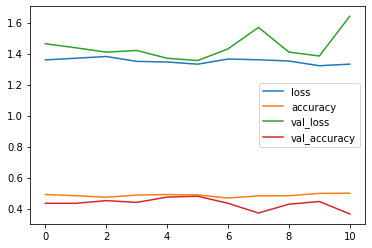

In [32]:
pd.DataFrame(history.history).plot();

In [39]:
vg_model.evaluate(validation_generator)

6/6 [==============================] - 1s 105ms/step - loss: 1.3553 - accuracy: 0.4800


[1.3553277254104614, 0.47999998927116394]

# Xception

In [35]:
def load_model():
    model = Xception(weights="imagenet", include_top=False, 
                     classes=7, input_shape=(224, 224, 3), classifier_activation="softmax")
    
    return model
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False 
    return model

def add_last_layers(model):
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(7, activation='softmax')
    
    
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    
    return model

def compile_model(model):
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

def build_model():
    
    model = load_model()
    model = add_last_layers(model)
    model = compile_model(model)
    
    return model

x_model = build_model()

83689472/83683744 [==============================] - 0s 0us/step


In [36]:
x_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 500)               50176500  
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 3507      
Total params: 71,041,487
Trainable params: 50,180,007
Non-trainable params: 20,861,480
_________________________________________________________________


In [37]:
keras.backend.clear_session()
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True)
history = x_model.fit(train_generator,
                    epochs=100,verbose=1,
                    validation_data=validation_generator,
                    callbacks=[es])

Epoch 1/100
99/99 [==============================] - 40s 380ms/step - loss: 2.1663 - accuracy: 0.2605 - val_loss: 1.7845 - val_accuracy: 0.3200
Epoch 2/100
99/99 [==============================] - 37s 372ms/step - loss: 1.5932 - accuracy: 0.3806 - val_loss: 1.6003 - val_accuracy: 0.3829
Epoch 3/100
99/99 [==============================] - 37s 371ms/step - loss: 1.5617 - accuracy: 0.3842 - val_loss: 1.6839 - val_accuracy: 0.3257
Epoch 4/100
99/99 [==============================] - 37s 373ms/step - loss: 1.5174 - accuracy: 0.4258 - val_loss: 1.6358 - val_accuracy: 0.3600
Epoch 5/100
99/99 [==============================] - 37s 375ms/step - loss: 1.4676 - accuracy: 0.4318 - val_loss: 1.6447 - val_accuracy: 0.3829
Epoch 6/100
99/99 [==============================] - 37s 375ms/step - loss: 1.4578 - accuracy: 0.4425 - val_loss: 1.6104 - val_accuracy: 0.4171
Epoch 7/100
99/99 [==============================] - 37s 375ms/step - loss: 1.4330 - accuracy: 0.4427 - val_loss: 1.5667 - val_accuracy:

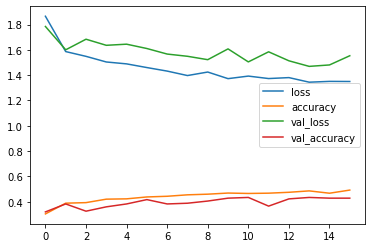

In [38]:
pd.DataFrame(history.history).plot();

In [40]:
x_model.evaluate(validation_generator)

6/6 [==============================] - 1s 122ms/step - loss: 1.5047 - accuracy: 0.4343


[1.5047041177749634, 0.4342857003211975]